# Feature selection in high-dimensional genetic data

# Notebook 4: Mutitask approaches

## Introduction

We will now repeat the previous analysis for the 4W phenotype. It is very similar to the 2W phenotype, except that the seeds have been vernelized for 4 weeks. 

Then, because it is not unreasonable to expect the genomic regions driving both those phenotypes to be (almost) the same, we will use multi-task versions of the Lasso and elastic net analyze both phenotypes simultaneously.

Check out the documentation: [sklearn.linear_model.MultiTaskLasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso) + [User Guide](http://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html)

__Q: Is our setting it the same "multi-task" setting as the one described in the documentation of scikit-learn? What is the difference?__

__A:__ In the "real" multi-task setting (Obozinski et al., *Multi-task feature selection*, 2006), there are one design matrix and one output for each task. Here, however, the design matrix is the same for both tasks: we use the same genomic data -- the "individuals" are the same --, and only the phenotypes differs.

Consequently, this setting is more restrictive than Obozinski's multi-task lasso.

Let us start with reloading the data.

In [1]:
%pylab inline 
# imports matplotlib as plt and numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rc('font', **{'size': 14}) # font size for text on plots

In [3]:
import pandas as pd

In [4]:
# Loading the SNP names
with open('data/athaliana_small.snps.txt') as f:
    snp_names = f.readline().split()
    f.close()
print(len(snp_names))

9419


In [5]:
# Loading the design matrix -- this can take time!
X = np.loadtxt('data/athaliana_small.X.txt',  # file names
               dtype = 'int') # values are integers
p = X.shape[1]

In [6]:
# Loading the sample names
samples = list(np.loadtxt('data/athaliana.samples.txt', # file names
                         dtype=int)) # values are integers

In [7]:
# Loading the list of candidate genes
with open('data/athaliana.candidates.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

In [8]:
# Loading the SNPs-to-gene mapping
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/athaliana.snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

## Loading the 4W and 2W phenotypes

### Loading the 2W phenotype
This is the same as in previous notebooks.

In [9]:
df_2W = pd.read_csv('data/athaliana.2W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True, # columns are separated by white space
                 index_col=0) # read the first column as index

# Create vector of sample IDs
samples_with_phenotype_2W = list(df_2W.index)
print(len(samples_with_phenotype_2W), "samples have a 2W phenotype")

152 samples have a 2W phenotype


### Loading the 4W phenotype

The 4W phenotype is very similar to the 2W phenotype; the only difference is that seeds have been vernalized for 4 weeks instead of 2.

In [10]:
df_4W = pd.read_csv('data/athaliana.4W.pheno', # file name
                 header=None, # columns have no header
                 delim_whitespace=True, # columns are separated by white space
                 index_col=0) # read the first column as index

# Create vector of sample IDs
samples_with_phenotype_4W = list(df_4W.index)
print(len(samples_with_phenotype_4W), "samples have a 4W phenotype")

119 samples have a 4W phenotype


### New design matrix

We will now restrict ourselves to samples with _both_ 2W and 4W phenotypes.

In [11]:
samples_with_phenotype_both = list(set(samples_with_phenotype_2W).intersection(samples_with_phenotype_4W))
print(len(samples_with_phenotype_both), "samples have both phenotypes")

117 samples have both phenotypes


Restricting the samples to those in both 2W and 4W

In [12]:
X_both = X[np.array([samples.index(sample_id) for sample_id in samples_with_phenotype_both]), :]
del X # You can delete X now if you want, to free space

Restricting the phenotypes to the samples in both 2W and 4W

In [13]:
# 2W phenotypes, ordered according to samples_with_phenotype_both
df_2W_both = df_2W.loc[samples_with_phenotype_both]

# 4W phenotypes, ordered according to samples_with_phenotype_both
df_4W_both = df_4W.loc[samples_with_phenotype_both]

# multitask phenotype matrix:
y_both = np.hstack((df_2W_both, df_4W_both))

## Preliminary analysis

Is it reasonable to expect the 2W and 4W phenotypes to share many explanatory SNPs?

### Correlation between the phenotypes

In [14]:
from scipy.stats.stats import pearsonr

In [15]:
print("The correlation between the two phenotypes is %.3f" % pearsonr(y_both[:, 0], y_both[:, 1])[0])

The correlation between the two phenotypes is 0.871


Text(0, 0.5, '4W')

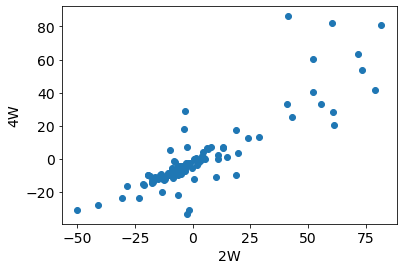

In [16]:
plt.scatter(y_both[:, 0], y_both[:, 1])
plt.xlabel("2W")
plt.ylabel("4W")

The two phenotypes are quite correlated, confirming our idea that they can be studied together.

### Manhattan plots

We will now plot the Manhattan plots for both phenotypes.

In [17]:
import statsmodels.api as sm

In [18]:
## Compute p-values for both 2W and 4W
pvalues_2W = []
pvalues_4W = []
for snp_idx in range(p):
    X_snp = sm.add_constant(X_both[:, snp_idx])
    ## 2W
    est_2W = sm.regression.linear_model.OLS(y_both[:, 0], X_snp).fit()
    pvalues_2W.append(est_2W.pvalues[1])
    ## 4W
    est_4W = sm.regression.linear_model.OLS(y_both[:, 1], X_snp).fit()
    pvalues_4W.append(est_4W.pvalues[1])
pvalues_2W = np.array(pvalues_2W)
pvalues_4W = np.array(pvalues_4W)

We can overlay the two Manhattan plots (and flip the second one):

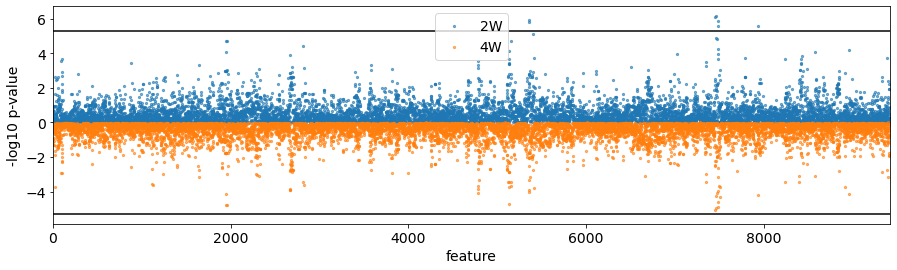

In [19]:
figure(figsize=(15, 4))

plt.scatter(range(p), -np.log10(pvalues_2W), alpha=0.6, s=5, label="2W")
t = -np.log10(0.05 / p)
plt.plot([0, p], [t, t], c="black")
plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])

plt.scatter(range(p), np.log10(pvalues_4W), alpha=0.6, s=5, label="4W")
plt.plot([0, p], [-t, -t], c="black")

plt.xlabel("feature")
plt.ylabel("-log10 p-value")
plt.xlim([0, p])
plt.legend()

There is no SNP significantly associated with the 4W phenotype, but the peaks of the two Manhattan plots correspond to the same regions.

Another possible visualization is to plot both pvalues ax xy-coordinates:

Text(0, 0.5, '4W')

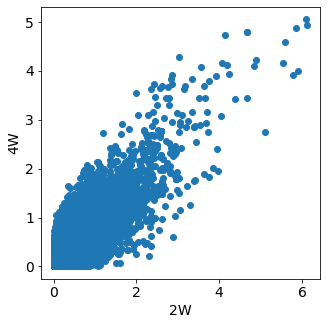

In [20]:
figure(figsize=(5, 5))
plt.scatter(-np.log10(pvalues_2W), -np.log10(pvalues_4W))
plt.xlabel('2W'); plt.ylabel('4W')

Most SNPs are in the upper-low left corner (low p-values for both phenotypes). But there is a number of SNPs with both large 4W-pvalues and 2W-pvalues, which shows that the two pvalues are correlated. Moreover, there are no SNPs with a high pvalue for one phenotype and a small pvalue for the other.

__Q: What conclusion can you draw? Do the 2W and 4W phenotypes seem to be linked to the same genome loci?__

__A:__ Comparison of the two pvalues indicates that the two phenotypes must be explained but the same set of SNPs (or at least, there is a large intersection between the two sets). This justifies using a multi-task setting.

## Train-test split

In [21]:
from sklearn import model_selection

In [22]:
X_both_tr, X_both_te, y_both_tr, y_both_te = \
    model_selection.train_test_split(X_both, y_both, test_size=0.1, random_state=17)

In [23]:
print(y_both.shape, y_both_tr.shape, y_both_te.shape)
print(X_both.shape, X_both_tr.shape, X_both_te.shape)

(117, 2) (105, 2) (12, 2)
(117, 9419) (105, 9419) (12, 9419)


## Lasso on the 2W phenotype

We have fewer samples than for our previous analysis of the 2W phenotype, because we've restricted ourselves to samples for which both the 2W and 4W phenotypes are available. This will affect our ability to train a Lasso model for this phenotype.

Here we re-run the same experiment as in Notebook 2, but restricted to the 117 samples that have both a 2W and a 4W phenotype.

In [24]:
from sklearn import linear_model

In [25]:
# # You can use the Lasso path to determine the most appropriate range of values for alpha
# alphas_lasso_2W, coefs_lasso_2W, _ = linear_model.lasso_path(X_both_tr, y_both_tr[:, 0], eps=1e-2, n_alphas=30, fit_intercept=True)
# alphas_lasso_2W

In [26]:
lasso = linear_model.Lasso(fit_intercept=True, max_iter=6000)

Define cross-validation grid search and learn lasso with cross-validation.

In [27]:
alphas = np.logspace(-2., 1., num=20)
model_l1_2W = model_selection.GridSearchCV(lasso, param_grid = {'alpha': alphas}, 
                                        scoring='explained_variance', verbose=1)
model_l1_2W.fit(X_both_tr, y_both_tr[:, 0])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Lasso(max_iter=6000),
             param_grid={'alpha': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])},
             scoring='explained_variance', verbose=1)

In [28]:
model_l1_2W.best_params_

{'alpha': 1.1288378916846884}

(0.0, 9419.0)

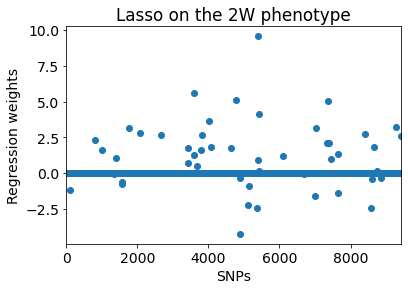

In [29]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1_2W.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNPs")
plt.ylabel("Regression weights")
plt.title("Lasso on the 2W phenotype")
plt.xlim([0, p])

In [30]:
selected_snps_2W = np.nonzero(model_l1_2W.best_estimator_.coef_)[0]
print("%d SNPs selected" % selected_snps_2W.shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps_2W:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("\t %d of the selected SNPs are in or near %d candidate genes" % (num_snps_in_candidate_genes, 
                                                                     len(candidate_genes_hit)))

54 SNPs selected
	 54 of the selected SNPs are in or near 38 candidate genes


In [31]:
from sklearn import metrics

In [32]:
y_2W_l1_pred = model_l1_2W.best_estimator_.predict(X_both_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1_2W.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_both_te[:, 0], y_2W_l1_pred)))

Percentage of variance explained (using 54 SNPs): 0.10


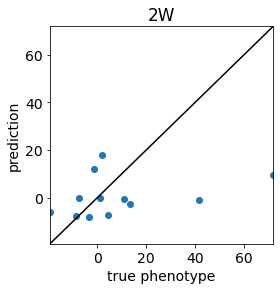

In [33]:
plt.figure(figsize = (4, 4))
plt.scatter(y_both_te[:, 0], y_2W_l1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.title("2W")
plt.xlim([np.min(y_both_te[:, 0]) - 0.05, np.max(y_both_te[:, 0]) + 0.05])
plt.ylim([np.min(y_both_te[:, 0]) - 0.05, np.max(y_both_te[:, 0]) + 0.05])
plt.axline(xy1=[0, 0], slope=1, c="black")

## Lasso on the 4W phenotype

Let us see how well a Lasso model performs on the 4W phenotype.

In [34]:
# # You can use the Lasso path to determine the most appropriate range of values for alpha
# alphas_lasso_4W, coefs_lasso_4W, _ = linear_model.lasso_path(X_both_tr, y_both_tr[:, 1], eps=1e-2, n_alphas=30, fit_intercept=True)
# alphas_lasso_4W

In [35]:
lasso = linear_model.Lasso(fit_intercept=True, max_iter=6000)

In [36]:
alphas = np.logspace(-2., 1., num=20)
model_l1_4W = model_selection.GridSearchCV(lasso, param_grid = {'alpha': alphas}, 
                                        scoring='explained_variance', verbose=1)
model_l1_4W.fit(X_both_tr, y_both_tr[:, 1])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Lasso(max_iter=6000),
             param_grid={'alpha': array([ 0.01      ,  0.0143845 ,  0.02069138,  0.02976351,  0.04281332,
        0.06158482,  0.08858668,  0.1274275 ,  0.18329807,  0.26366509,
        0.37926902,  0.54555948,  0.78475997,  1.12883789,  1.62377674,
        2.33572147,  3.35981829,  4.83293024,  6.95192796, 10.        ])},
             scoring='explained_variance', verbose=1)

In [37]:
model_l1_4W.best_params_

{'alpha': 0.26366508987303583}

(0.0, 9419.0)

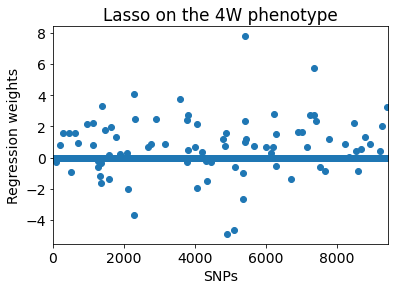

In [38]:
plt.figure(figsize = (6, 4))
plt.scatter(range(p), # x = SNP position
            model_l1_4W.best_estimator_.coef_)  # y = regression weights

plt.xlabel("SNPs")
plt.ylabel("Regression weights")
plt.title("Lasso on the 4W phenotype")
plt.xlim([0, p])

In [39]:
selected_snps_4W = np.nonzero(model_l1_4W.best_estimator_.coef_)[0]
print("%d SNPs selected" % selected_snps_4W.shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps_4W:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("\t %d of the selected SNPs are in or near %d candidate genes" % (num_snps_in_candidate_genes, 
                                                                     len(candidate_genes_hit)))

89 SNPs selected
	 89 of the selected SNPs are in or near 62 candidate genes


In [40]:
y_4W_l1_pred = model_l1_4W.best_estimator_.predict(X_both_te)

print("Percentage of variance explained (using %d SNPs): %.2f" % \
     (np.nonzero(model_l1_4W.best_estimator_.coef_)[0].shape[0], 
      metrics.explained_variance_score(y_both_te[:, 1], y_4W_l1_pred)))

Percentage of variance explained (using 89 SNPs): -0.03


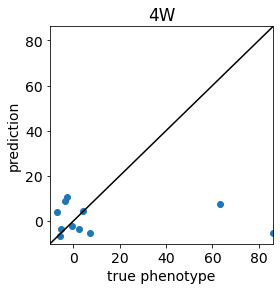

In [41]:
plt.figure(figsize = (4, 4))
plt.scatter(y_both_te[:, 1], y_4W_l1_pred)

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.title("4W")
plt.xlim([np.min(y_both_te[:, 1]) - 0.05, np.max(y_both_te[:, 1]) + 0.05])
plt.ylim([np.min(y_both_te[:, 1]) - 0.05, np.max(y_both_te[:, 1]) + 0.05])
plt.axline(xy1=[0, 0], slope=1, c="black")

## Multitask lasso

We can now cross-validate a multitask Lasso on the data training data.

In [43]:
mt_l1 = linear_model.MultiTaskLasso(fit_intercept=True, max_iter=6000)
alphas = np.logspace(-3., 1, num=10)
model_mt_l1 = model_selection.GridSearchCV(mt_l1,
                                          param_grid = {'alpha': alphas}, verbose=2)

model_mt_l1.fit(X_both_tr, y_both_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........................................alpha=0.001; total time=   6.4s
[CV] END ........................................alpha=0.001; total time=   7.7s
[CV] END ........................................alpha=0.001; total time=   7.3s
[CV] END ........................................alpha=0.001; total time=   7.7s
[CV] END ........................................alpha=0.001; total time=   7.5s
[CV] END ........................alpha=0.0027825594022071257; total time=   7.3s
[CV] END ........................alpha=0.0027825594022071257; total time=   8.0s
[CV] END ........................alpha=0.0027825594022071257; total time=   7.4s
[CV] END ........................alpha=0.0027825594022071257; total time=   6.6s
[CV] END ........................alpha=0.0027825594022071257; total time=   6.3s
[CV] END .........................alpha=0.007742636826811269; total time=   6.4s
[CV] END .........................alpha=0.007742

GridSearchCV(estimator=MultiTaskLasso(max_iter=6000),
             param_grid={'alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])},
             verbose=2)

In [ ]:
model_mt_l1.best_params_

In [ ]:
plt.figure(figsize = (8, 5))
#plt.spy(ml_lasso_cv.best_estimator_.coef_)
plt.scatter(range(p), model_mt_l1.best_estimator_.coef_[0, :], alpha=0.7, label="2W")
plt.scatter(range(p), model_mt_l1.best_estimator_.coef_[1, :], alpha=0.7, label="4W")

plt.xlabel("features")
plt.ylabel("MTLasso regression weights")
plt.xlim([0, p])
plt.legend()

In [ ]:
selected_snps_mt_l1_2W = np.nonzero(model_mt_l1.best_estimator_.coef_[0, :])[0]
print("%d SNPs selected for 2W," % selected_snps_mt_l1_2W.shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps_mt_l1_2W:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("\t of which %d are in/near %d candidate genes" % (num_snps_in_candidate_genes, 
                                                          len(candidate_genes_hit)))

In [ ]:
selected_snps_mt_l1_4W = np.nonzero(model_mt_l1.best_estimator_.coef_[1, :])[0]
print("%d SNPs selected for 4W," % selected_snps_mt_l1_4W.shape)

candidate_genes_hit = set([])
num_snps_in_candidate_genes = 0
for snp_idx in selected_snps_mt_l1_4W:
    for gene_id in genes_by_snp[snp_names[snp_idx]]:
        if gene_id in candidate_genes:
            candidate_genes_hit.add(gene_id)
            num_snps_in_candidate_genes += 1
            break

print("\t of which %d are in/near %d candidate genes" % (num_snps_in_candidate_genes, 
                                                          len(candidate_genes_hit)))

In [ ]:
y_l1_mt_pred = model_mt_l1.best_estimator_.predict(X_both_te)

print("Percentage of variance explained for 2W (using %d SNPs): %.2f" % \
     (np.nonzero(model_mt_l1.best_estimator_.coef_[1, :])[0].shape[0], 
      metrics.explained_variance_score(y_both_te[:, 0], y_l1_mt_pred[:, 0])))

print("Percentage of variance explained for 4W (using %d SNPs): %.2f" % \
     (np.nonzero(model_mt_l1.best_estimator_.coef_[0, :])[0].shape[0], 
      metrics.explained_variance_score(y_both_te[:, 1], y_l1_mt_pred[:, 1])))

In [ ]:
plt.figure(figsize = (4, 4))
plt.scatter(y_both_te[:, 0], y_l1_mt_pred[:, 0], alpha=0.7, label="2W")
plt.scatter(y_both_te[:, 1], y_l1_mt_pred[:, 1], alpha=0.7, label="4W")

plt.xlabel("true phenotype")
plt.ylabel("prediction")
plt.title("Multitask")
plt.xlim([np.min(y_both_te) - 0.05, np.max(y_both_te) + 0.05])
plt.ylim([np.min(y_both_te) - 0.05, np.max(y_both_te) + 0.05])
plt.axline(xy1=[0, 0], slope=1, c="black")

Note that what we lost in predictive ability from having fewer samples is not compensated by the multitask here.

## Multitask elastic-net
See the [user guide](https://scikit-learn.org/stable/modules/linear_model.html#multi-task-elastic-net) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNet.html#sklearn.linear_model.MultiTaskElasticNet).

__Q: Do the same as before, but with (multi-task) elastic net instead!__